##### Data Description

The dataset contains text from works of fiction written by: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

* EAP - [Edgar Allen Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe)  : American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction.

* HPL - [H.P. Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft) : Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.

* MWS - [Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley) : Novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.

##### File descriptions

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

##### Data fields

* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: H.P. Lovecraft; MWS: Mary Wollstonecraft Shelley)

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import itertools

# visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py

from PIL import Image

# NLTK imports
import nltk, re
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss

# wordcloud
from wordcloud import WordCloud, STOPWORDS

# import spacy

<IPython.core.display.Javascript object>

In [52]:
# Plot confusion matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_conf_matrix(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = "d"
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

<IPython.core.display.Javascript object>

##### Load the data

In [4]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


<IPython.core.display.Javascript object>

##### EDA & Data Visualization

In [5]:
# no null values
train_df.isnull().sum()

id        0
text      0
author    0
dtype: int64

<IPython.core.display.Javascript object>

In [6]:
train_df["text"][0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

<IPython.core.display.Javascript object>

In [7]:
train_df.shape

(19579, 3)

<IPython.core.display.Javascript object>

In [8]:
test_df = pd.read_csv("data/test.csv")
test_df.shape

(8392, 2)

<IPython.core.display.Javascript object>

In [9]:
train_stats = train_df.drop(columns=["id", "text"])

<IPython.core.display.Javascript object>

In [10]:
eng_stopwords = stopwords.words("english")
## Number of words in the text ##
train_stats["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_stats["num_unique_words"] = train_df["text"].apply(
    lambda x: len(set(str(x).split()))
)

## Number of characters in the text ##
train_stats["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_stats["num_stopwords"] = train_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords])
)

## Number of punctuations in the text ##
train_stats["num_punctuations"] = train_df["text"].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

## Number of title case words in the text ##
train_stats["num_words_upper"] = train_df["text"].apply(
    lambda x: len([w for w in str(x).split() if w.isupper()])
)

## Average length of the words in the text ##
train_stats["mean_word_len"] = train_df["text"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()])
)

train_stats.head(10)

,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,mean_word_len
0,EAP,41,35,231,19,7,2,4.658537
1,HPL,14,14,71,8,1,0,4.142857
2,EAP,36,32,200,16,5,0,4.583333
3,MWS,34,32,206,13,4,0,5.088235
4,HPL,27,25,174,11,4,0,5.481481
5,MWS,83,66,468,43,6,5,4.650602
6,EAP,21,21,128,9,5,0,5.142857
7,EAP,8,8,43,4,1,0,4.500000
8,EAP,88,62,488,45,11,4,4.556818
9,MWS,23,18,144,11,3,1,5.304348


<IPython.core.display.Javascript object>

In [11]:
train_df["text"][8]

"I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could not avoid casting your eyes upward to the great nebula in Orion, and I certainly expected that you would do so."

<IPython.core.display.Javascript object>

/Users/cri/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



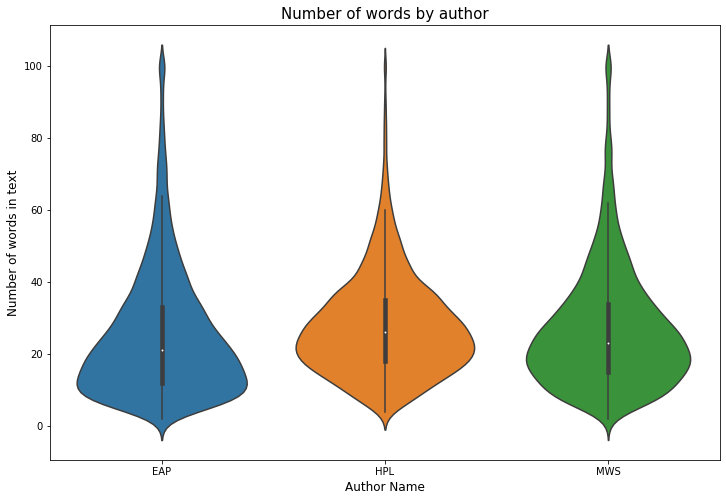

<IPython.core.display.Javascript object>

In [12]:
train_stats['num_words'].loc[train_stats['num_words']>100] = 100 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_stats)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()




* EAP seems to have used less number of words than MWS and HPL.


In [13]:
author_stats = train_df["author"].value_counts()
author_stats

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
# replace author names
df_names = train_df.replace(
    {
        "author": {
            "EAP": "Edagr Allen Poe",
            "HPL": "H.P. Lovecraft",
            "MWS": "Mary Shelley",
        }
    }
)
df_names

,id,text,author
0,id26305,"This process, however, afforded me no means of...",Edagr Allen Poe
1,id17569,It never once occurred to me that the fumbling...,H.P. Lovecraft
2,id11008,"In his left hand was a gold snuff box, from wh...",Edagr Allen Poe
3,id27763,How lovely is spring As we looked from Windsor...,Mary Shelley
4,id12958,"Finding nothing else, not even gold, the Super...",H.P. Lovecraft
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",Edagr Allen Poe
19575,id08973,The lids clenched themselves together as if in...,Edagr Allen Poe
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",Edagr Allen Poe
19577,id17513,"For an item of news like this, it strikes us i...",Edagr Allen Poe


<IPython.core.display.Javascript object>

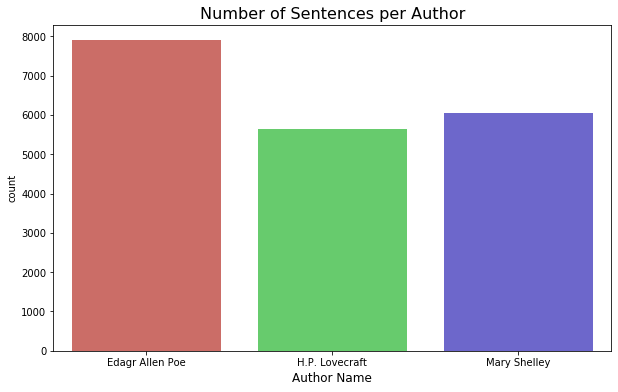

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x="author", data=df_names, palette="hls")
plt.xlabel("Author Name", fontsize=12)
plt.title("Number of Sentences per Author", fontsize=16)
plt.show()

##### Having fun with wordCloud

In [16]:
df_eap = train_df["text"][train_df["author"] == "EAP"]
df_eap.head()

0    This process, however, afforded me no means of...
2    In his left hand was a gold snuff box, from wh...
6    The astronomer, perhaps, at this point, took r...
7          The surcingle hung in ribands from my body.
8    I knew that you could not say to yourself 'ste...
Name: text, dtype: object

<IPython.core.display.Javascript object>

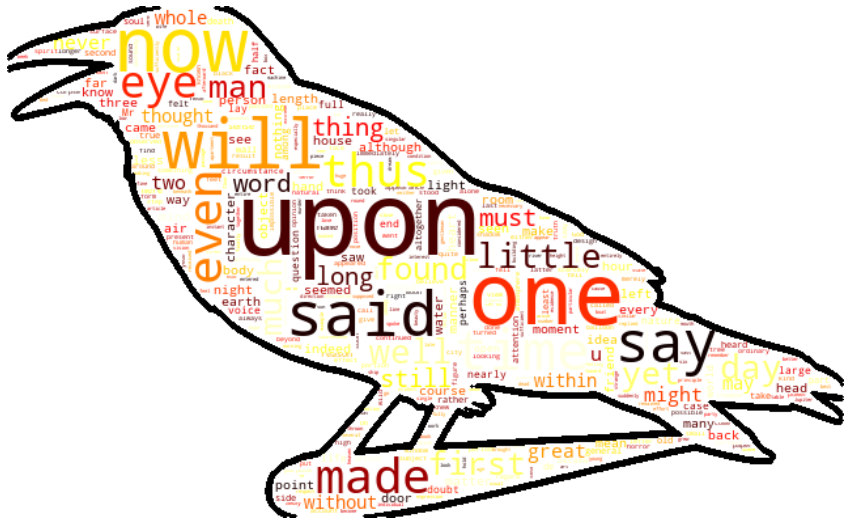

<IPython.core.display.Javascript object>

In [17]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("img/eap_mask.png"))

wordcloud = WordCloud(
    random_state=1,
    mask=mask,
    max_words=2000,
    width=mask.shape[1],
    height=mask.shape[0],
    background_color="white",
    colormap="hot",
    contour_width=3,
    contour_color="black",
    # collocations=False,
    stopwords=stopwords,
    # max_font_size= 40
).generate(" ".join(train_df["text"][train_df["author"] == "EAP"]))

plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

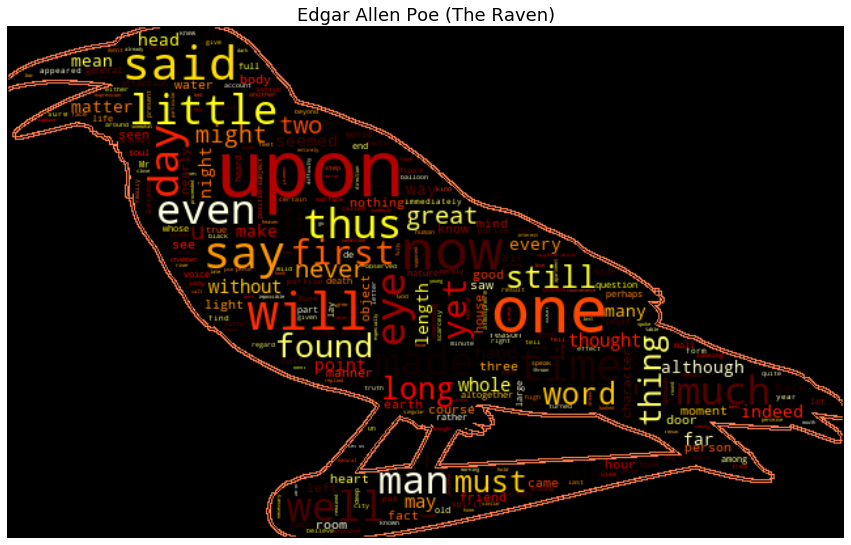

<IPython.core.display.Javascript object>

In [18]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("img/eap_mask.png"))

wordcloud = WordCloud(
    random_state=1,
    mask=mask,
    max_words=2000,
    width=mask.shape[1],
    height=mask.shape[0],
    background_color="black",
    colormap="hot",
    contour_width=0.5,
    contour_color="coral",  # collocations=False,
    stopwords=stopwords,
    max_font_size=60,
).generate(" ".join(train_df["text"][train_df["author"] == "EAP"]))

plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Edgar Allen Poe (The Raven)", fontsize=18)
plt.axis("off")
plt.show()

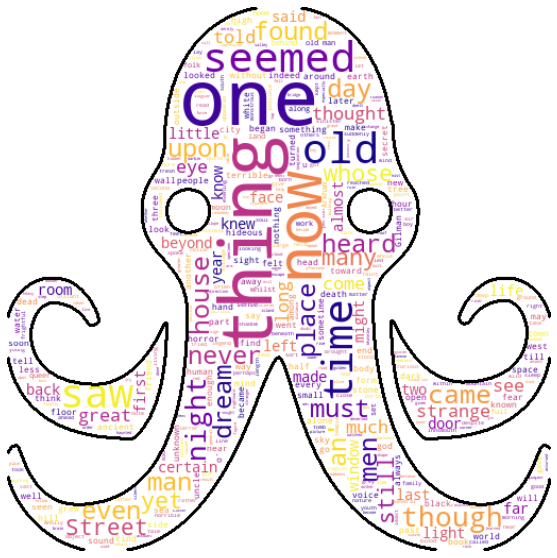

<IPython.core.display.Javascript object>

In [19]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("img/hpl_mask.png"))

wordcloud = WordCloud(
    random_state=1,
    mask=mask,
    max_words=2000,
    width=mask.shape[1],
    height=mask.shape[0],
    background_color="white",
    colormap="plasma",
    contour_width=3,
    contour_color="black",
    # collocations=False,
    stopwords=stopwords,
).generate(" ".join(train_df["text"][train_df["author"] == "HPL"]))

plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

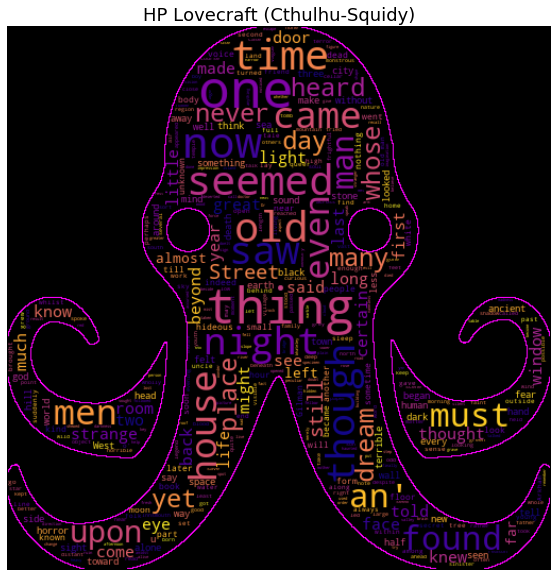

<IPython.core.display.Javascript object>

In [20]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("img/hpl_mask.png"))

wordcloud = WordCloud(
    random_state=1,
    mask=mask,
    max_words=2000,
    width=mask.shape[1],
    height=mask.shape[0],
    background_color="black",
    colormap="plasma",
    contour_width=1,
    contour_color="fuchsia",  # collocations=False,
    stopwords=stopwords,
    max_font_size=50,
).generate(" ".join(train_df["text"][train_df["author"] == "HPL"]))

plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=18)
plt.axis("off")
plt.show()

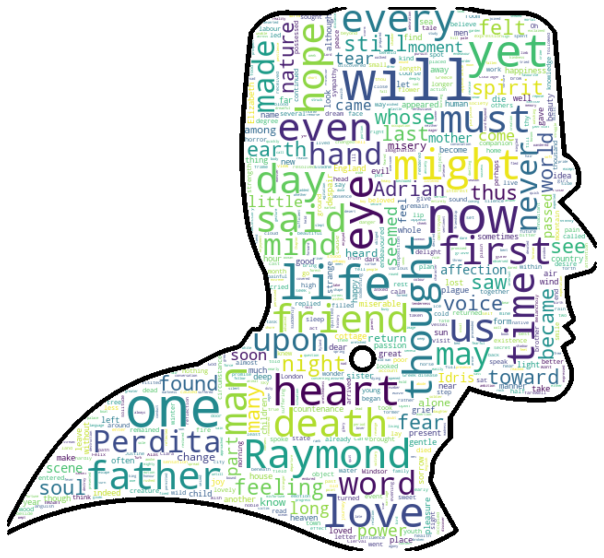

<IPython.core.display.Javascript object>

In [21]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("img/mws_mask.png"))

wordcloud = WordCloud(
    random_state=1,
    mask=mask,
    max_words=2000,
    width=mask.shape[1],
    height=mask.shape[0],
    background_color="white",
    colormap="viridis",
    contour_width=3,
    contour_color="black",
    # collocations=False,
    stopwords=stopwords,
    max_font_size=60,
).generate(" ".join(train_df["text"][train_df["author"] == "MWS"]))

plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

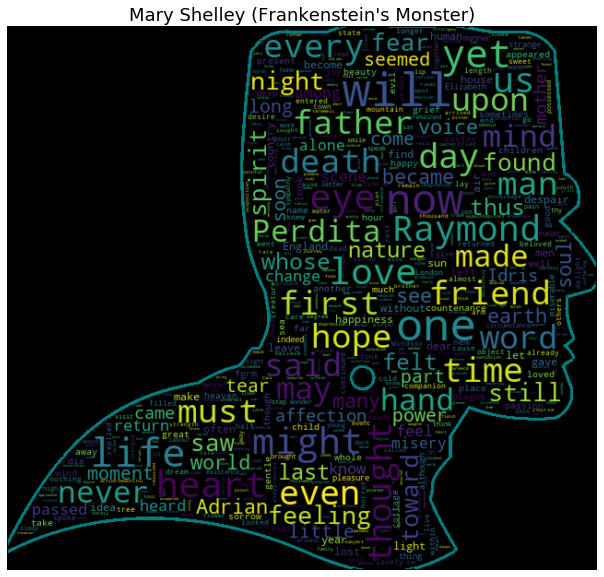

<IPython.core.display.Javascript object>

In [22]:
stopwords = set(STOPWORDS)
mask = np.array(Image.open("img/mws_mask.png"))

wordcloud = WordCloud(
    random_state=1,
    mask=mask,
    max_words=2000,
    width=mask.shape[1],
    height=mask.shape[0],
    background_color="black",
    colormap="viridis",
    contour_width=1,
    contour_color="teal",  # collocations=False,
    stopwords=stopwords,
    max_font_size=50,
).generate(" ".join(train_df["text"][train_df["author"] == "MWS"]))

plt.figure(figsize=(15, 10))
# Display the generated image
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=18)
plt.axis("off")
plt.show()

##### Data cleaning and preprocessing

In [23]:
# word tokenization
train_df["tokenized"] = train_df.text.apply(nltk.word_tokenize)
train_df.head()

,id,text,author,tokenized
0,id26305,"This process, however, afforded me no means of...",EAP,"[This, process, ,, however, ,, afforded, me, n..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[It, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[In, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[How, lovely, is, spring, As, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[Finding, nothing, else, ,, not, even, gold, ,..."


<IPython.core.display.Javascript object>

In [24]:
# Unique words and mapping to integers
unique_words = {word for sentence in train_df.tokenized.values for word in sentence}
dict_words = {word: i for i, word in enumerate(unique_words)}

<IPython.core.display.Javascript object>

In [25]:
# Stemming and removing stopwords + punctuations
stopwords = nltk.corpus.stopwords.words("english") + ["", "'s'", "would", "could", "us"]
stemmer = EnglishStemmer()

<IPython.core.display.Javascript object>

In [26]:
# Create dictionaries from words to stem and conversely
stemmed_dict = {item: stemmer.stem(item) for item in unique_words}
reverse_stemmer = {item: [] for item in stemmed_dict.values()}

<IPython.core.display.Javascript object>

In [27]:
#stopwords


<IPython.core.display.Javascript object>

In [28]:
for item in stemmed_dict:
    reverse_stemmer[stemmed_dict[item]].append(item)

<IPython.core.display.Javascript object>

In [29]:
train_df["stemmed"] = train_df["tokenized"].apply(
    lambda x: [
        stemmed_dict[y] for y in x if re.sub("[^a-z]+", "", y.lower()) not in stopwords
    ]
)
train_df.head()

,id,text,author,tokenized,stemmed
0,id26305,"This process, however, afforded me no means of...",EAP,"[This, process, ,, however, ,, afforded, me, n...","[process, howev, afford, mean, ascertain, dime..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[It, never, once, occurred, to, me, that, the,...","[never, occur, fumbl, might, mere, mistak]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[In, his, left, hand, was, a, gold, snuff, box...","[left, hand, gold, snuff, box, caper, hill, cu..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[How, lovely, is, spring, As, we, looked, from...","[love, spring, look, windsor, terrac, sixteen,..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[Finding, nothing, else, ,, not, even, gold, ,...","[find, noth, els, even, gold, superintend, aba..."


<IPython.core.display.Javascript object>

In [30]:
# Count of words
test = pd.Series(y for x in train_df.stemmed for y in x)
word_count = {"ALL": pd.Series([y for x in train_df.stemmed for y in x]).value_counts()}
authors = ["EAP", "HPL", "MWS"]
authors_dict = {author: i for i, author in enumerate(authors)}
for author in authors:
    word_count[author] = pd.Series(
        [y for x in train_df.loc[train_df.author == author, "stemmed"] for y in x]
    ).value_counts()

<IPython.core.display.Javascript object>

In [31]:
word_count_frame = (
    pd.DataFrame(word_count)
    .fillna(0)
    .astype(int)
    .sort_values("ALL", ascending=False)[["ALL"] + authors]
)

<IPython.core.display.Javascript object>

In [32]:
from matplotlib.colors import LinearSegmentedColormap

word_count_frame.head(25).style.background_gradient(
    subset=authors, cmap=LinearSegmentedColormap.from_list("", ["violet", "blue"])
)

,ALL,EAP,HPL,MWS
one,1677,672,516,489
upon,1411,1025,186,200
time,874,315,281,278
even,828,296,234,298
man,786,258,279,249
day,743,258,197,288
eye,732,270,176,286
thing,725,221,433,71
yet,715,232,165,318
said,704,356,140,208


<IPython.core.display.Javascript object>

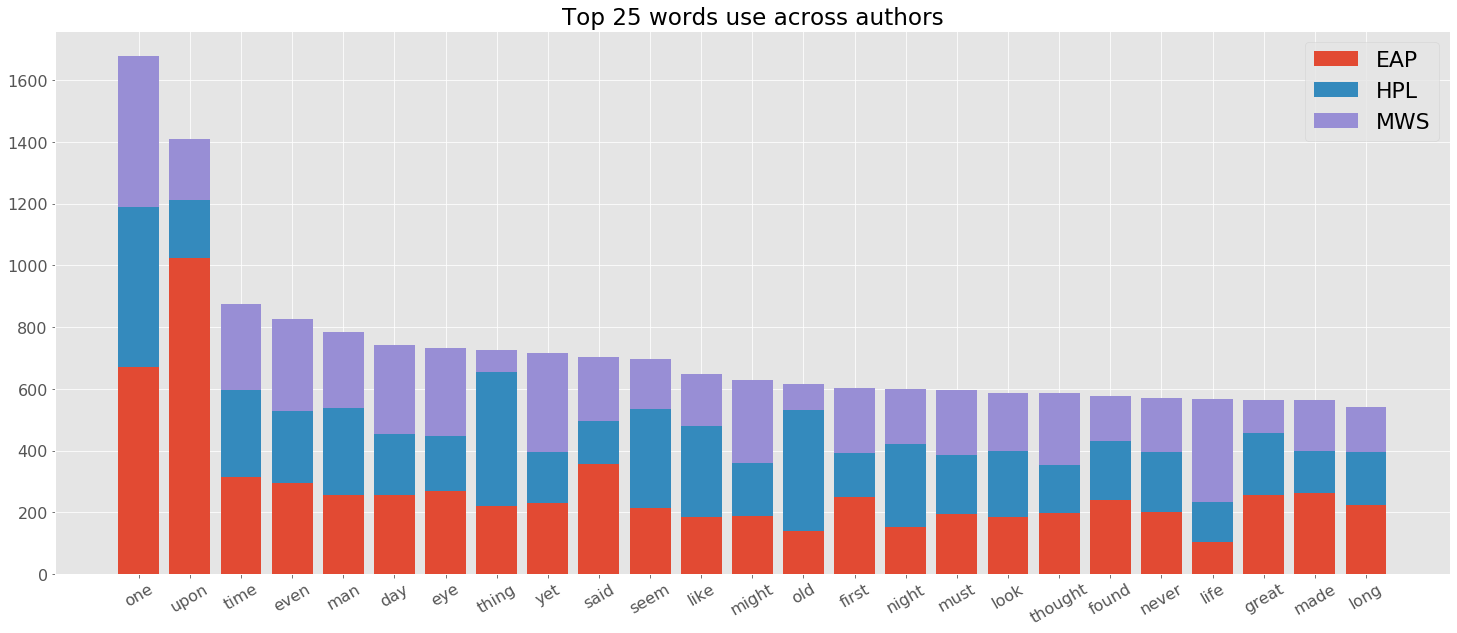

<IPython.core.display.Javascript object>

In [33]:
# visualization for top words by author
plt.style.use("ggplot")
plt.rcParams["font.size"] = 16
plt.figure(figsize=(25, 10))
bottom = np.zeros(25)
index = np.arange(25)
word_count_25 = word_count_frame.head(25)

for author in authors:
    # Stacked bars
    values = word_count_25[author]
    plt.bar(index, values, bottom=bottom, label=author)
    bottom += values

plt.xticks(index, word_count_25.index, rotation=30)
plt.title("Top 25 words use across authors")
plt.legend(fontsize=22)

* EAP loves to use "upon", HPL is using "thing" and "old" more than EAP & MWS, especially MWS

##### Grammer: Parts of Speech

In [34]:
#
train_df["tagged"] = [[x[1] for x in nltk.pos_tag(y)] for y in train_df.tokenized]

train_df = train_df[["id", "text", "author", "tokenized", "tagged", "stemmed"]]
train_df.head()

,id,text,author,tokenized,tagged,stemmed
0,id26305,"This process, however, afforded me no means of...",EAP,"[This, process, ,, however, ,, afforded, me, n...","[DT, NN, ,, RB, ,, VBD, PRP, DT, NNS, IN, VBG,...","[process, howev, afford, mean, ascertain, dime..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[It, never, once, occurred, to, me, that, the,...","[PRP, RB, RB, VBD, TO, PRP, IN, DT, NN, MD, VB...","[never, occur, fumbl, might, mere, mistak]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[In, his, left, hand, was, a, gold, snuff, box...","[IN, PRP$, JJ, NN, VBD, DT, JJ, NN, NN, ,, IN,...","[left, hand, gold, snuff, box, caper, hill, cu..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[How, lovely, is, spring, As, we, looked, from...","[WRB, RB, VBZ, JJ, IN, PRP, VBD, IN, NNP, NNP,...","[love, spring, look, windsor, terrac, sixteen,..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[Finding, nothing, else, ,, not, even, gold, ,...","[VBG, NN, RB, ,, RB, RB, NN, ,, DT, NNP, VBD, ...","[find, noth, els, even, gold, superintend, aba..."


<IPython.core.display.Javascript object>

In [35]:
# Get the count and explanation for each parts of speech tags
tags_info = nltk.data.load("help/tagsets/upenn_tagset.pickle")
tags = pd.Series([x for y in train_df.tagged for x in y]).value_counts().to_frame()
tags.columns = ["count"]
tags["explanation"] = [tags_info[i][0] for i in tags.index]

tags.head()

,count,explanation
NN,84783,"noun, common, singular or mass"
IN,71911,"preposition or conjunction, subordinating"
DT,59511,determiner
JJ,38616,"adjective or numeral, ordinal"
",",38220,comma


<IPython.core.display.Javascript object>

In [36]:
# Add the percentages for each parts of speech tags
tags["percentage"] = (tags["count"] / tags["count"].sum()).apply("{:.0%}".format)

tags.head(20)

,count,explanation,percentage
NN,84783,"noun, common, singular or mass",14%
IN,71911,"preposition or conjunction, subordinating",12%
DT,59511,determiner,10%
JJ,38616,"adjective or numeral, ordinal",6%
",",38220,comma,6%
PRP,34441,"pronoun, personal",6%
VBD,34140,"verb, past tense",6%
RB,29458,adverb,5%
CC,23640,"conjunction, coordinating",4%
NNS,23429,"noun, common, plural",4%


<IPython.core.display.Javascript object>

=====================================================================================================================

### Modeling

##### Load the train data

In [37]:
train = pd.read_csv("data/train.csv")

<IPython.core.display.Javascript object>

##### Preprocess the train data

In [38]:
train["text_processed"] = train["text"].map(lambda x: re.sub("[,\.!?]", "", x))
train["text_processed"] = train["text_processed"].map(lambda x: x.lower())


def cleanText(input_string):
    modified_string = re.sub("[^A-Za-z0-9]+", " ", input_string)
    return modified_string


train["text_processed"] = train.text_processed.apply(cleanText)

# stopWords = stopwords.words("english")
stopwords = nltk.corpus.stopwords.words("english") + ["", "'s'", "would", "could", "us"]


def removeStopWords(stopwords, rvw_txt):
    newtxt = " ".join([word for word in rvw_txt.split() if word not in stopwords])
    return newtxt


train["text_processed"] = [
    removeStopWords(stopwords, x) for x in train["text_processed"]
]

train.head()

,id,text,author,text_processed
0,id26305,"This process, however, afforded me no means of...",EAP,process however afforded means ascertaining di...
1,id17569,It never once occurred to me that the fumbling...,HPL,never occurred fumbling might mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else even gold superintendent ...


<IPython.core.display.Javascript object>

##### Load the test data

In [39]:
test = pd.read_csv("data/test.csv")

<IPython.core.display.Javascript object>

##### Preprocess the test data

In [40]:
test["text_processed"] = test["text"].map(lambda x: re.sub("[,\.!?]", "", x))
test["text_processed"] = test["text_processed"].map(lambda x: x.lower())


def cleanText(input_string):
    modified_string = re.sub("[^A-Za-z0-9]+", " ", input_string)
    return modified_string


test["text_processed"] = test.text_processed.apply(cleanText)

# stopWords = stopwords.words("english")
stopwords = nltk.corpus.stopwords.words("english") + ["", "'s'", "would", "could", "us"]


def removeStopWords(stopwords, rvw_txt):
    newtxt = " ".join([word for word in rvw_txt.split() if word not in stopwords])
    return newtxt


test["text_processed"] = [removeStopWords(stopwords, x) for x in test["text_processed"]]

test.head()

,id,text,text_processed
0,id02310,"Still, as I urged our leaving Ireland with suc...",still urged leaving ireland inquietude impatie...
1,id24541,"If a fire wanted fanning, it could readily be ...",fire wanted fanning readily fanned newspaper g...
2,id00134,And when they had broken down the frail door t...,broken frail door found two cleanly picked hum...
3,id27757,While I was thinking how I should possibly man...,thinking possibly manage without one actually ...
4,id04081,I am not sure to what limit his knowledge may ...,sure limit knowledge may extend


<IPython.core.display.Javascript object>

##### Split training dataset for training and testing

In [41]:
# split our data for validation purposes

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['text'], train['author'], test_size=0.2, random_state=42)


<IPython.core.display.Javascript object>

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15663,) (3916,) (15663,) (3916,)


<IPython.core.display.Javascript object>

### Building a modelling pipeline: vectorizer -> transformer -> classifier

### RandomForestClassifier

In [43]:
model = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        # ("clf", MultinomialNB()),
        ("clf", RandomForestClassifier(n_estimators=100)),
        # ("clf", LogisticRegression()),
        # ("clf", KNeighborsClassifier()),
        # ("clf", GradientBoostingClassifier()),
    ]
)

# alternatively
# model = Pipeline([
#                   ('tfidf', TfidfVectorizer()),
#                   ('clf', RandomForestClassifier(n_estimators=100))
#                   ])

model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

Train score: 1.0000
Test score: 0.6964
              precision    recall  f1-score   support

         EAP       0.62      0.89      0.73      1570
         HPL       0.79      0.57      0.66      1071
         MWS       0.81      0.57      0.67      1275

    accuracy                           0.70      3916
   macro avg       0.74      0.67      0.69      3916
weighted avg       0.73      0.70      0.69      3916



<IPython.core.display.Javascript object>

### K Nearest Neighbors Classifier

In [44]:
model = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        # ("clf", MultinomialNB()),
        # ("clf", RandomForestClassifier(n_estimators=100)),
        # ("clf", LogisticRegression()),
        ("clf", KNeighborsClassifier()),
        # ("clf", GradientBoostingClassifier()),
    ]
)

# alternatively
# model = Pipeline([
#                   ('tfidf', TfidfVectorizer()),
#                   ('clf', RandomForestClassifier(n_estimators=100))
#                   ])

model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

Train score: 0.8080
Test score: 0.6992
              precision    recall  f1-score   support

         EAP       0.64      0.84      0.73      1570
         HPL       0.79      0.53      0.63      1071
         MWS       0.75      0.66      0.71      1275

    accuracy                           0.70      3916
   macro avg       0.73      0.68      0.69      3916
weighted avg       0.72      0.70      0.69      3916



<IPython.core.display.Javascript object>

### Gradient Boosting Classifier

In [45]:
model = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        # ("clf", MultinomialNB()),
        # ("clf", RandomForestClassifier(n_estimators=100)),
        # ("clf", LogisticRegression()),
        # ("clf", KNeighborsClassifier()),
        ("clf", GradientBoostingClassifier()),
    ]
)

# alternatively
# model = Pipeline([
#                   ('tfidf', TfidfVectorizer()),
#                   ('clf', RandomForestClassifier(n_estimators=100))
#                   ])

model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

Train score: 0.6967
Test score: 0.6703
              precision    recall  f1-score   support

         EAP       0.62      0.84      0.71      1570
         HPL       0.71      0.57      0.63      1071
         MWS       0.75      0.55      0.63      1275

    accuracy                           0.67      3916
   macro avg       0.69      0.65      0.66      3916
weighted avg       0.69      0.67      0.66      3916



<IPython.core.display.Javascript object>

### Logistic Regression

Logistic regression is the go-to linear classification algorithm for two-class problems. It is easy to implement, easy to understand and gets great results on a wide variety of problems.

In [46]:
# create the pipeline

model = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        # ("clf", MultinomialNB()),
        # ("clf", RandomForestClassifier(n_estimators=100)),
        ("clf", LogisticRegression()),
        # ("clf", KNeighborsClassifier()),
        # ("clf", GradientBoostingClassifier()),
    ]
)

model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

/Users/cri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Train score: 0.9242
Test score: 0.8128
              precision    recall  f1-score   support

         EAP       0.79      0.85      0.82      1570
         HPL       0.80      0.79      0.79      1071
         MWS       0.86      0.79      0.82      1275

    accuracy                           0.81      3916
   macro avg       0.82      0.81      0.81      3916
weighted avg       0.81      0.81      0.81      3916



<IPython.core.display.Javascript object>

##### Model Optimization (hyperparameters tuning)

Now, let's see if we can improve the overall accuracy of the model through optimizing the parameters by using Grid Search with cross validation. 

In [47]:
# parameters = {
#     "vect__max_df": (0.5, 1.0),
#     "vect__max_features": (None, 5000, 10000),
#     "vect__ngram_range": ((1, 1), (1, 2)),
#     "tfidf__use_idf": (True, False),
#     "tfidf__norm": ("l1", "l2"),
#     # "clf__penalty": ("l1", "l2", "none", "elasticnet"),
#     "clf__C": (0.2, 0.5),
# }

# model_cv = GridSearchCV(model, parameters, verbose=1, cv=2, n_jobs=-1)
# model_cv.fit(X_train, y_train)

# model_cv.best_score_

<IPython.core.display.Javascript object>

### Multinomial variant of Naive Bayes

In [48]:
# create the pipeline

model = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
        # ("clf", RandomForestClassifier(n_estimators=100)),
        # ("clf", LogisticRegression()),
        # ("clf", KNeighborsClassifier()),
        # ("clf", GradientBoostingClassifier()),
    ]
)

model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train score: {model.score(X_train, y_train):.4f}")
print(f"Test score: {model.score(X_test, y_test):.4f}")

Train score: 0.9010
Test score: 0.8146


<IPython.core.display.Javascript object>

##### Model Optimization (hyperparameters tuning)

In [49]:
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__max_features": (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "tfidf__use_idf": (True, False),
    "tfidf__norm": ("l1", "l2"),
    "clf__alpha": (1e-2, 1e-3),
}

model_cv = GridSearchCV(model, parameters, verbose=1, cv=2, n_jobs=-1)
model_cv.fit(X_train, y_train)

model_cv.best_score_
model_cv.best_params_

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
/Users/cri/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:   53.7s finished


{'clf__alpha': 0.01,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False,
 'vect__max_df': 0.75,
 'vect__max_features': None,
 'vect__ngram_range': (1, 2)}

<IPython.core.display.Javascript object>

##### Model Evaluation (classification model metrics)

In [50]:
predictions = model_cv.best_estimator_.predict(X_test)
predictions_prob = model_cv.best_estimator_.predict_proba(X_test)

# Log Loss is the most important classification metric based on probabilities.
# a lower log-loss value means better predictions
print(classification_report(y_test, predictions))
print("Accuracy score:", accuracy_score(y_test, predictions))
print("Log Loss:", log_loss(y_test, predictions_prob))

              precision    recall  f1-score   support

         EAP       0.84      0.86      0.85      1570
         HPL       0.87      0.81      0.84      1071
         MWS       0.84      0.87      0.86      1275

    accuracy                           0.85      3916
   macro avg       0.85      0.85      0.85      3916
weighted avg       0.85      0.85      0.85      3916

Accuracy score: 0.8503575076608785
Log Loss: 0.3851259770875557


<IPython.core.display.Javascript object>

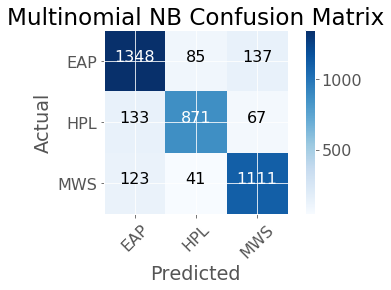

<IPython.core.display.Javascript object>

In [58]:
# Confusion Matrix
conf_mx = confusion_matrix(y_test, predictions)
plot_conf_matrix(
    conf_mx, train.author.unique(), title="Multinomial NB Confusion Matrix"
)
# plot_conf_matrix(conf_mx, train.author.unique(), title=" ")